# Introduction to swyft-lightning

In this notebook, we will go through the basic steps of performing parameter inference with Swyft.

## Setup

First we need some imports.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft

## Training data

Now we generate training data.  As simple example, we consider the model

$$
x = z + \epsilon
$$

where the parameter $z \sim \mathcal{N}(\mu = 0, \sigma = 1)$ is standard normal distributed, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the posterior of $z$ given a measurement of parameter $x$.

In [3]:
N = 10000  # Number of samples
z = np.random.randn(N, 1)
x = z + np.random.randn(N, 1)*0.1
x, z = swyft.to_numpy32(x, z)  # Convenience function to convert to single precision

Training data that is kept in memory is stored in a `swyft.Samples` object.

In [4]:
samples = swyft.Samples(x = x, z = z)

## Inference network

The inference network is an instance of `swyft.SwyftModule`.  It estimates ratios of the form
$$
r(A; B) = \frac{p(A, B)}{p(A)p(B)}\;,
$$
where $A$ and $B$ refer to any subset of variables in the training data.  In the below example, we set $A \to x$ and $B \to z$.

We use here a standard dense network, `swyft.RatioEstimatorMLP1d`, for mapping $x$ and $z$ onto a ratio estimator object.

In [5]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 1, varnames = 'z')

    def forward(self, A, B):
        logratios = self.logratios(A['x'], B['z'])
        return logratios

## Trainer

Training is now done using the `SwyftTrainer` class, which extends `pytorch_lightning.Trainer` by methods like `infer` (see below).

In [6]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


The `swyft.Samples` class provides convenience functions to generate data loaders for training and validation data.

In [7]:
dl_train = samples[:-500].get_dataloader(batch_size = 64, shuffle = True)
dl_valid = samples[-500:].get_dataloader(batch_size = 64)

In [8]:
network = Network()

In [9]:
trainer.fit(network, dl_train, dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 17.4 K
-----------------------------------------------------
17.4 K    Trainable params
0         Non-trainable params
17.4 K    Total params
0.070     Total estimated model params size (MB)
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/weniger/codes/swyft/notebooks/lightning_logs/version_9927147/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  95%|█████████▍| 149/157 [00:01<00:00, 94.99it/s, loss=-0.981, v_num=9927147]
Validating: 0it [00:00, ?it/s]
Epoch 1:  95%|█████████▍| 149/157 [00:01<00:00, 93.86it/s, loss=-0.975, v_num=9927147, val_loss=-.973]
Validating: 0it [00:00, ?it/s]
Epoch 2:  95%|█████████▍| 149/157 [00:01<00:00, 94.51it/s, loss=-0.993, v_num=9927147, val_loss=-.975]
Validating: 0it [00:00, ?it/s]
Epoch 3:  95%|█████████▍| 149/157 [00:01<00:00, 97.21it/s, loss=-0.992, v_num=9927147, val_loss=-.975]
Validating: 0it [00:00, ?it/s]
Epoch 4:  95%|█████████▍| 149/157 [00:01<00:00, 94.67it/s, loss=-0.954, v_num=9927147, val_loss=-.960] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  95%|█████████▍| 149/157 [00:01<00:00, 96.51it/s, loss=-1.01, v_num=9927147, val_loss=-.977] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  95%|█████████▍| 149/157 [00:01<00:00, 96.98it/s, loss=-0.987, v_num=9927147, val_loss=-.967]
Validating: 0it [00:00, ?it/s]
Epoch 7:  95%|█████████▍| 149/157 [00:01<00:00, 97.37it/s, loss=-1.01, v_num=

## Inference

We assume that we measure the values $x=0.2$.

In [10]:
x0 = 0.2

Below we will need that this is a `Sample` object.

In [29]:
A = swyft.Sample(x = swyft.to_numpy32(np.array([x0])))

We first generate a large number of prior samples.

In [30]:
B = swyft.Samples(z = swyft.to_numpy32(np.random.randn(100000, 1)))

Swyft provides the method `infer` in order to efficiently evaluate the inference network. That method takes either dataloaders or individual samples (i.e. dictionaries of tensors) as input.  This efficiently evaluates the ratio $r(x; z)$ for a large number of prior samples $z$ for a fixed values of $x$.

In [31]:
predictions = trainer.infer(network, A, B)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 149it [00:00, ?it/s]


## Plot results

First we obtain samples from the posterior, using subsampling with a weight that happens to be given by $e^r$.

In [32]:
post_samples = predictions.sample(1_000_000)[:,0].numpy()
parname = predictions.parnames[0]

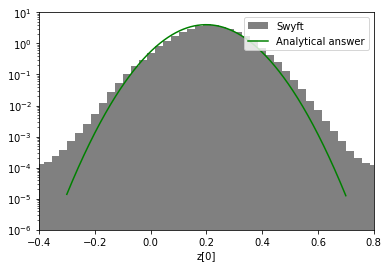

In [33]:
# Plot swyft results
#plt.hist(post_samples, bins = 50, density = True, color = '0.5', label = "Swyft");
plt.hist(predictions.params[:,0].numpy(), weights = predictions.weights.numpy(), bins = 300, density = True, color = '0.5', label = "Swyft");
plt.xlabel(parname)

# Compare with analytical result
xn = np.linspace(x0-0.5, x0+0.5, 1000)
sigma_eff = (1/0.1**2 + 1/1**2)**-0.5
mu_eff = x0/(1**2 + 0.1**2)**0.5
yn = stats.norm.pdf(xn, mu_eff, sigma_eff)
plt.plot(xn, yn, 'g', label = "Analytical answer")
plt.xlim([x0-0.6, x0+0.6])
plt.ylim([1e-6, 1e1])
plt.yscale('log')
plt.legend(loc=1)